In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
from sklearn.metrics import roc_curve, roc_auc_score
sb.set()

In [48]:
parts = []
for i in glob.glob("../data/ss_discovery/*/*/*/truvari/data.jl"):
    d = joblib.load(i)
    i = i.split('/')
    d["sample"] = i[-3]
    d["reference"] = i[-4]
    d["program"] = i[-5]
    parts.append(d)
data = pd.concat(parts)
#data = data[~(data["sample"] == "NA18939")]
idx = data[(data["qual"] == 0) & (data["state"].isin(["tp", "fp"]))].index
data = data.drop(index=idx)
# Remove manta's DUPs, they shouldn't be penalized for them
idx = data[(data["svtype"] == "DUP")].index
data = data.drop(index=idx)

In [49]:
metadata = pd.read_csv("../lra_sr_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [50]:
def acc(grp):
    view = grp["state"].value_counts()
    fp = view["fp"] if "fp" in view else 0
    tp = view["tp"] if "tp" in view else 0
    fn = view["fn"] if "fn" in view else 0
    tpbase = view["tpbase"] if "tpbase" in view else 0
    if tp + fp != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    if tpbase + fn != 0:
        recall = tpbase / (tpbase + fn)
    else:
        recall = 0
    neum = recall * precision
    denom = recall + precision
    if denom != 0:
        f1 = 2 * (neum / denom)
    else:
        f1 = None
    return precision, recall, f1

summary = []
for samp, dat in data.groupby(["sample", "reference", "program"]):
    summary.append([*samp, metadata.loc[samp[0]]["Superpopulation code"], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Reference", "Program", 
                                         "Superpopulation", "Precision", "Recall", "F1"])

In [51]:
grab = (summary["Program"] == "biograph") & (summary["F1"] > 0.550)
grab = grab | (summary["Program"] == "biograph") & (summary["Reference"] == "chm13") & (summary["F1"] > 0.52)
grab = grab | (summary["Program"] == "manta") & (summary["F1"] > 0.475)
grab = grab | (summary["Precision"] < 0.750)
grab = grab | ((summary["Program"] == "biograph") & (summary["Precision"] > 0.831) & (summary["Reference"] == "hg19"))
summary[grab]

,Sample,Reference,Program,Superpopulation,Precision,Recall,F1
12,HG00513,chm13,biograph,EAS,0.786743,0.392351,0.523588
13,HG00513,grch38,biograph,EAS,0.800072,0.444291,0.571320
14,HG00513,grch38,manta,EAS,0.866687,0.337403,0.485716
15,HG00513,hg19,biograph,EAS,0.797037,0.441221,0.568007
83,HG03486,hg19,biograph,AFR,0.838747,0.372058,0.515463
101,NA18939,grch38,biograph,EAS,0.661733,0.397657,0.496782
102,NA18939,grch38,manta,EAS,0.707268,0.292900,0.414248
123,NA19983,hg19,biograph,AFR,0.835990,0.354076,0.497458


In [52]:
# Just remove the EAS samples
grab = summary["Sample"].isin(["HG00513", "NA18939"])

In [47]:
metadata.loc[["HG00513", "NA18939"]]

,FamilyId,TrioState,Sex,Population code,Population name,Superpopulation code,Superpopulation name,AltIDs
Individual,,,,,,,,
HG00513,SH032,mother,female,CHS,Southern Han Chinese,EAS,East Asian Ancestry,NaN
NA18939,NA18939,unrel,female,JPT,Japanese,EAS,East Asian Ancestry,NaN


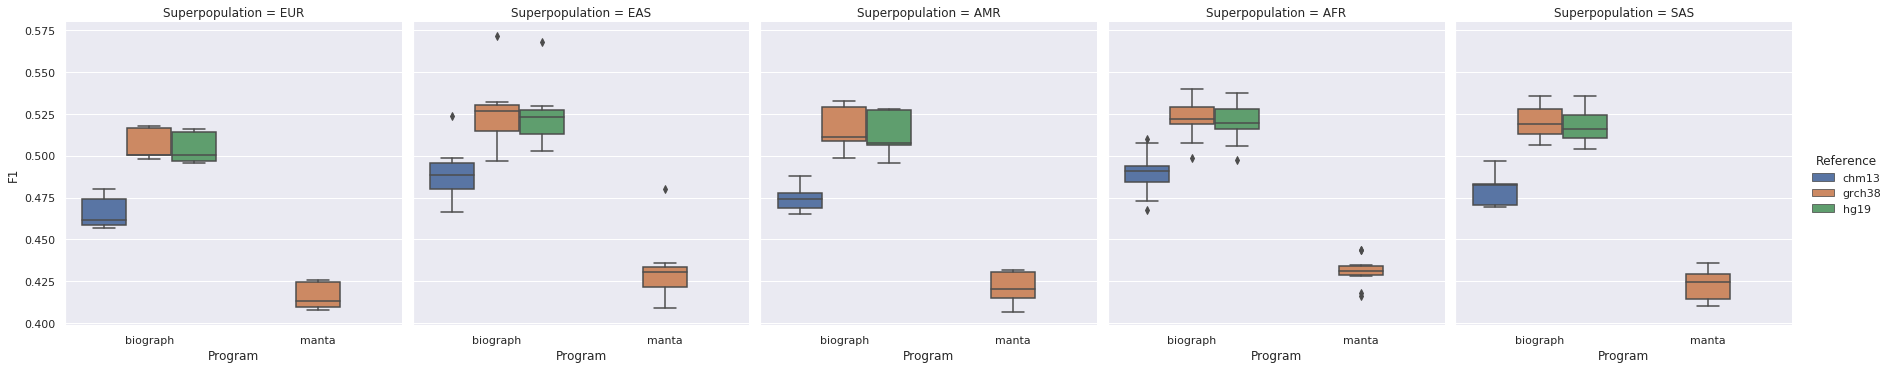

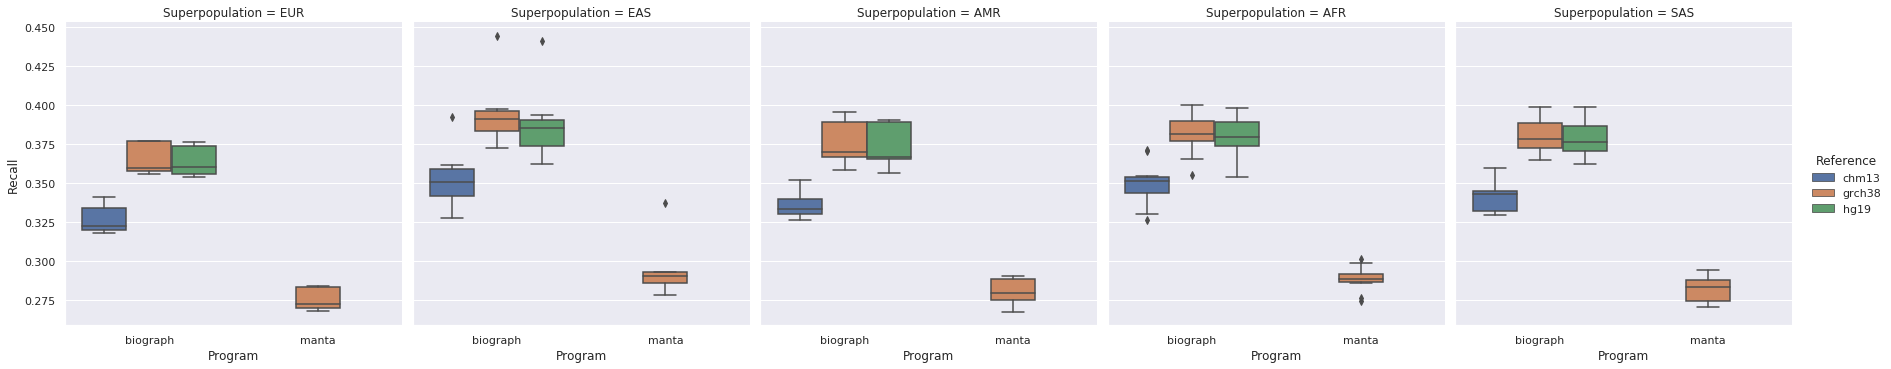

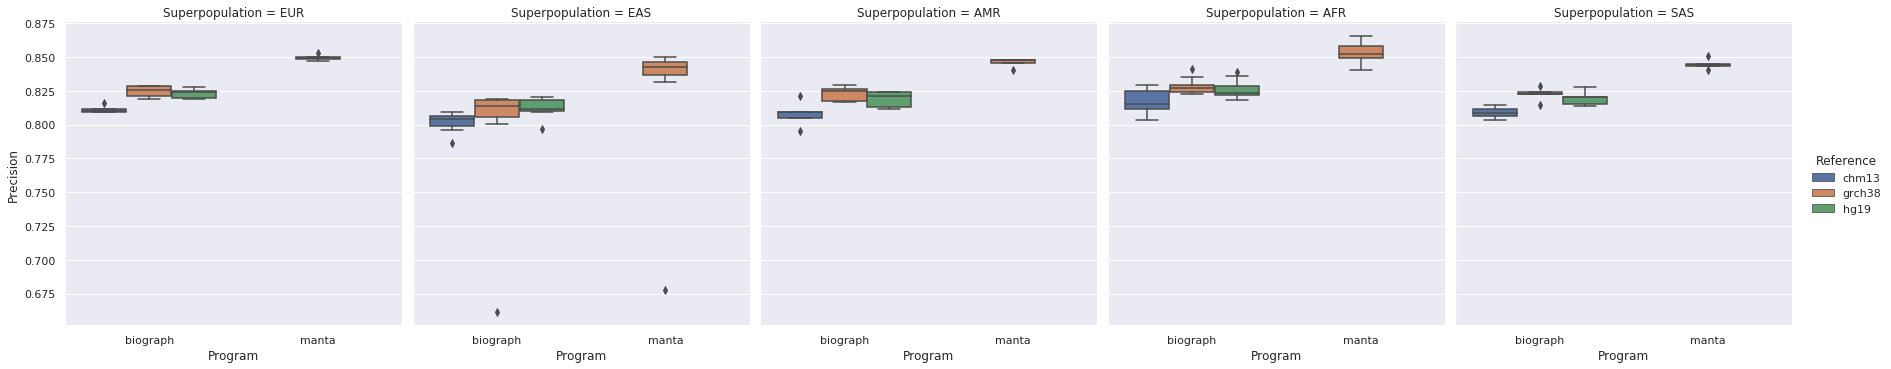

In [30]:
for y in ["F1", "Recall", "Precision"]:
    sb.catplot(data=summary,#[~grab], 
           x="Program", 
           y=y, 
           hue="Reference", 
           col="Superpopulation",
           kind="box")

In [40]:
summary.groupby(["Program"]).mean()

,Precision,Recall,F1
Program,,,
biograph,0.816207,0.367780,0.506525
manta,0.842940,0.285738,0.426475


In [53]:
summary.groupby(["Program", "Reference"]).mean()

Precision    Recall        F1
Program  Reference                               
biograph chm13       0.810023  0.343861  0.482491
         grch38      0.818194  0.381193  0.519573
         hg19        0.820404  0.378287  0.517511
manta    grch38      0.879927  0.285738  0.431067

In [41]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "program", "reference"]):
    summary.append([samp[0], samp[2], samp[3], metadata.loc[samp[0]]["Superpopulation code"], samp[1], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Program", "Reference", "Superpopulation", "svtype", "Precision", "Recall", "F1"])

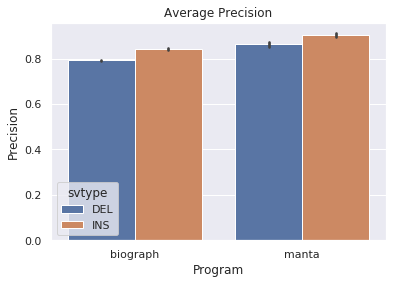

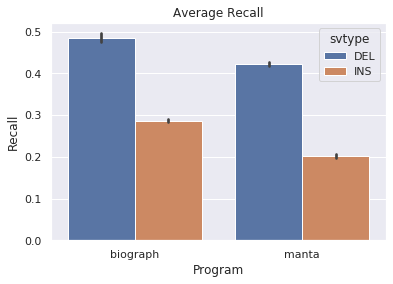

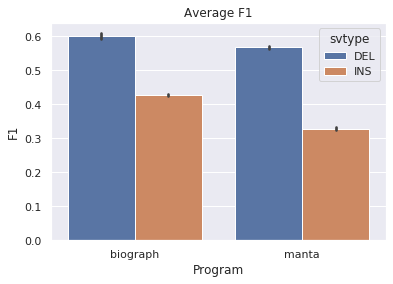

In [44]:
for i in ["Precision", "Recall", "F1"]:
    p = sb.barplot(data=summary, 
                   x="Program", 
                   y=i,
                  hue="svtype",
                  hue_order=["DEL", "INS"])
    p.set(title="Average " + i)
    plt.show()

In [45]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "szbin", "reference", "program"]):
    summary.append([samp[0], metadata.loc[samp[0]]["Superpopulation code"], samp[1], samp[2], samp[3], samp[4], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "svtype", "szbin", "Reference", "Program", "Precision", "Recall", "F1"])
summary["szbin"] = summary["szbin"].astype(truvari.SZBINTYPE)

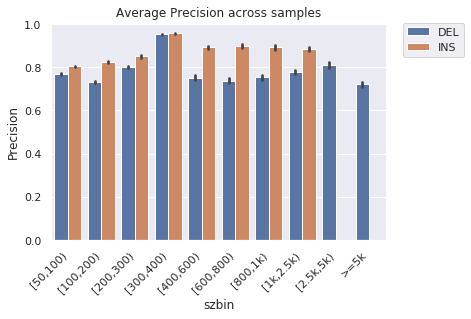

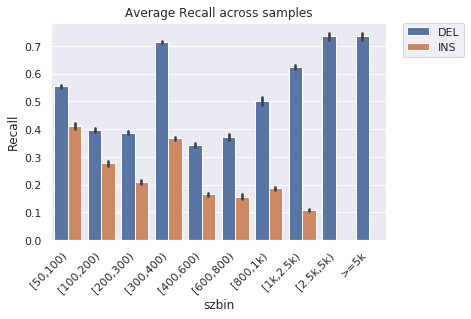

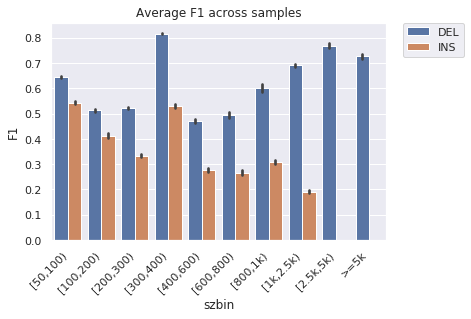

In [227]:
p = sb.barplot(data=summary, x="szbin", y="Precision", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average Precision across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

p = sb.barplot(data=summary, x="szbin", y="Recall", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average Recall across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

p = sb.barplot(data=summary, x="szbin", y="F1", hue="svtype", order=truvari.SZBINS[1:])
p.set(title="Average F1 across samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = plt.xticks(rotation=45, ha="right")
plt.show()

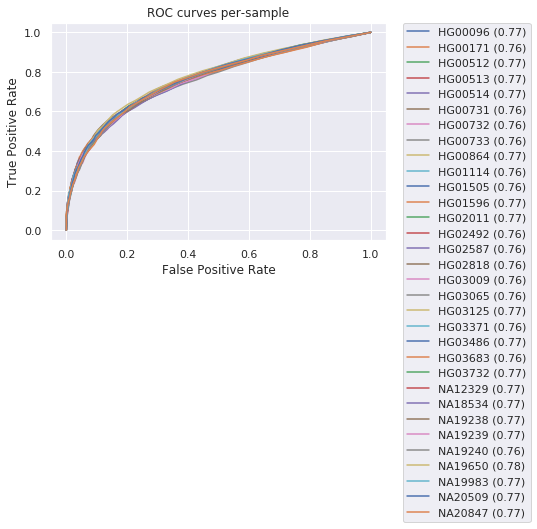

In [228]:
for samp, dat in data.groupby("sample"):
    view = dat[dat["state"].isin(["tp", "fp"])]
    #view.loc[view["state"] == "fn", "qual"] = -1
    fpr, tpr, thresholds = roc_curve(view["state"] == "tp", view["qual"])
    auc = roc_auc_score(view["state"] == "tp", view["qual"])
    plt.plot(fpr, tpr, label="%s (%.2f)" % (samp, auc))
plt.title("ROC curves per-sample")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)